**IMPORT LIBRARY**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

**LOAD DATASET**

In [5]:
df = pd.read_csv("name_gender_dataset.csv")

df.head()

,Name,Gender,Count,Probability
0,James,M,5304407,0.014517
1,John,M,5260831,0.014398
2,Robert,M,4970386,0.013603
3,Michael,M,4579950,0.012534
4,William,M,4226608,0.011567


**CEK DATA**

In [6]:
print("SHAPE:", df.shape)
print("\nINFO:")
print(df.info())

print("\nMISSING VALUES:")
print(df.isnull().sum())

print("\nDUPLICATE NAMES:")
print(df["Name"].duplicated().sum())

print("\nGENDER DISTRIBUTION:")
print(df["Gender"].value_counts(normalize=True))

SHAPE: (147269, 4)

INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147269 entries, 0 to 147268
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Name         147269 non-null  object 
 1   Gender       147269 non-null  object 
 2   Count        147269 non-null  int64  
 3   Probability  147269 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.5+ MB
None

MISSING VALUES:
Name           0
Gender         0
Count          0
Probability    0
dtype: int64

DUPLICATE NAMES:
13359

GENDER DISTRIBUTION:
Gender
F    0.609422
M    0.390578
Name: proportion, dtype: float64


**DATA CLEANING**

In [7]:
# Lowercase
df["Name"] = df["Name"].str.lower()

# Remove whitespace
df["Name"] = df["Name"].str.strip()

# Remove non-alphabet characters
df = df[df["Name"].str.isalpha()]

# Reset index
df = df.reset_index(drop=True)

print("After cleaning:", df.shape)

After cleaning: (139529, 4)


**TARGET TABEL**

In [8]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["Gender"])

label_encoder.classes_

array(['F', 'M'], dtype=object)

**TF-IDF**

In [9]:
tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(2, 4),
    min_df=5,
    max_features=5000
)

X = tfidf.fit_transform(df["Name"])

print("TF-IDF shape:", X.shape)

TF-IDF shape: (139529, 5000)


**SIMPAN TF-IDF DAN ENCODER**

In [10]:
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

**TRAIN-TEST SPLIT**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape

((111623, 5000), (27906, 5000))

# **MODEL 1 - BASELINE**

**LOGISTIC REGRESSION**

In [12]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)

# Accuracy
baseline_acc = accuracy_score(y_test, y_pred_baseline)

# Precision, Recall, F1
baseline_precision = precision_score(y_test, y_pred_baseline)
baseline_recall = recall_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline)

print("=== Logistic Regression (Baseline) ===")
print("Accuracy :", baseline_acc)
print("Precision:", baseline_precision)
print("Recall   :", baseline_recall)
print("F1-score :", baseline_f1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))


=== Logistic Regression (Baseline) ===
Accuracy : 0.7840249408729305
Precision: 0.7430602247622706
Recall   : 0.6976911976911977
F1-score : 0.7196613795990511

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82     16818
           1       0.74      0.70      0.72     11088

    accuracy                           0.78     27906
   macro avg       0.78      0.77      0.77     27906
weighted avg       0.78      0.78      0.78     27906



**SAVE BASELINE MODEL**

In [13]:
with open("baseline_logistic_regression.pkl", "wb") as f:
    pickle.dump(baseline_model, f)

# **MACHINE LEARNING**

**RANDOM FOREST**

In [14]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',
    oob_score=True,
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rf_acc = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", rf_acc)
print("OOB Score:", rf_model.oob_score_)
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.6805346520461549
OOB Score: 0.6726929037922292
              precision    recall  f1-score   support

           0       0.83      0.59      0.69     16818
           1       0.57      0.82      0.67     11088

    accuracy                           0.68     27906
   macro avg       0.70      0.70      0.68     27906
weighted avg       0.73      0.68      0.68     27906



**SAVE RANDOM FOREST**

In [15]:
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

# **SPARSE**

In [16]:
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# **BUILD MPL MODEL**

In [17]:
model_dl = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_dense.shape[1],)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model_dl.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_dl.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,449 (2.47 MB)

 Trainable params: 648,449 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

# **TRAIN DEEP LEARNING**

In [18]:
import time


In [19]:
start_time = time.time()

history = model_dl.fit(
    X_train_dense,
    y_train,
    epochs=10,
    batch_size=256,
    validation_split=0.1,
    verbose=1
)

training_time = time.time() - start_time
training_time

Epoch 1/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6836 - loss: 0.5785 - val_accuracy: 0.7764 - val_loss: 0.4694
Epoch 2/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7917 - loss: 0.4485 - val_accuracy: 0.7848 - val_loss: 0.4576
Epoch 3/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8086 - loss: 0.4208 - val_accuracy: 0.7866 - val_loss: 0.4563
Epoch 4/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8211 - loss: 0.3983 - val_accuracy: 0.7845 - val_loss: 0.4644
Epoch 5/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8303 - loss: 0.3799 - val_accuracy: 0.7863 - val_loss: 0.4634
Epoch 6/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8408 - loss: 0.3583 - val_accuracy: 0.7842 - val_loss: 0.4713
Epoch 7/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8483 - loss: 0.3397 - val_accuracy: 0.7840 - val_loss: 0.4822
Epoch 8/10
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8548 - loss: 0.3222 - val_accuracy: 0

32.32067894935608

# **TRAINING CURVES**

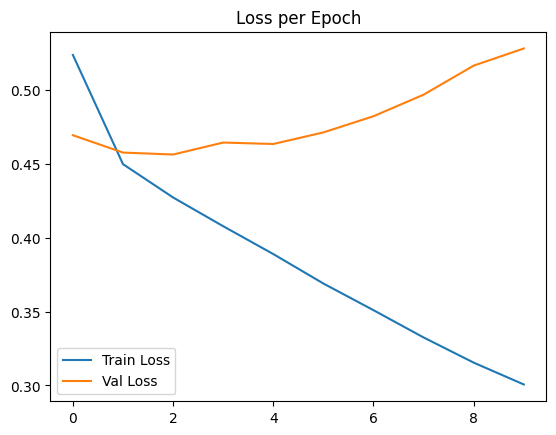

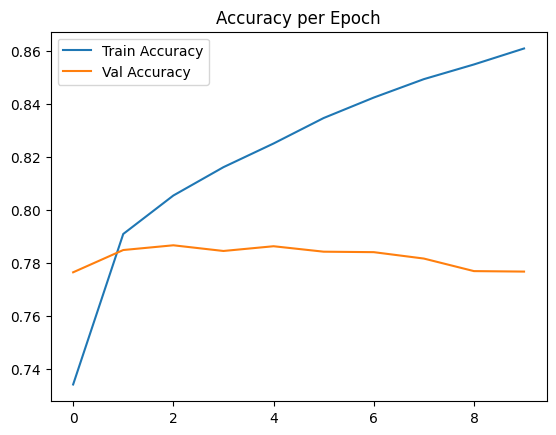

In [20]:
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss per Epoch")
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy per Epoch")
plt.show()

# **DL EVALUATION**

In [21]:
loss, dl_acc = model_dl.evaluate(X_test_dense, y_test, verbose=0)
dl_acc

0.7726295590400696

In [22]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# Prediksi probabilitas
y_pred_prob_dl = model_dl.predict(X_test_dense)

# Konversi ke label (0/1)
y_pred_dl = (y_pred_prob_dl >= 0.5).astype(int)


873/873 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [23]:
dl_acc = accuracy_score(y_test, y_pred_dl)
dl_precision = precision_score(y_test, y_pred_dl)
dl_recall = recall_score(y_test, y_pred_dl)
dl_f1 = f1_score(y_test, y_pred_dl)

print("=== Deep Learning (MLP) Evaluation ===")
print("Accuracy :", dl_acc)
print("Precision:", dl_precision)
print("Recall   :", dl_recall)
print("F1-score :", dl_f1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dl))


=== Deep Learning (MLP) Evaluation ===
Accuracy : 0.7726295420339712
Precision: 0.7222795013590777
Recall   : 0.69498556998557
F1-score : 0.7083697200900859

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81     16818
           1       0.72      0.69      0.71     11088

    accuracy                           0.77     27906
   macro avg       0.76      0.76      0.76     27906
weighted avg       0.77      0.77      0.77     27906



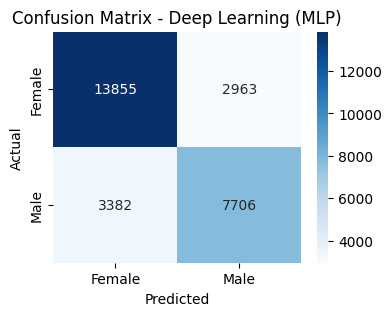

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_dl = confusion_matrix(y_test, y_pred_dl)

plt.figure(figsize=(4,3))
sns.heatmap(
    cm_dl,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Female", "Male"],
    yticklabels=["Female", "Male"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Deep Learning (MLP)")
plt.show()

# **SAVE DL MODEL**

In [25]:
model_dl.save("deep_learning_model.keras")

# **FINAL COMPARISON**

In [26]:
pd.DataFrame({
    "Model": [
        "Logistic Regression (Baseline)",
        "Random Forest (Optimized)",
        "Deep Learning (MLP)"
    ],
    "Accuracy": [
        baseline_acc,
        rf_acc,
        dl_acc
    ]
})

,Model,Accuracy
0,Logistic Regression (Baseline),0.784025
1,Random Forest (Optimized),0.680535
2,Deep Learning (MLP),0.772630
